# Compiler design: Phase 1 & 2 
    Aya Mohamed Safan   -  1710172 (CE)
    Salma Hossam Eldin Zakzouk - 1710100 (CE)
    Mena Nabil Shaltout - 18100682 (CS)


Grammar:

    Letter           ~ /[a-z|A-Z|_]/
    Digit            ~ /[0-9]/
    Ident            ~ /Letter(Letter|Digit)*/
    Constant         ~ Digit(.Digit+)?
    Op               ~ (.|;|,|(|)|+|-|*|/|=|<|>|!)
    RW               ~ (BEGIN|CALL|DECLARE|DO|ELSE|END|ENDIF|ENDUNTIL|ENDWHILE|IF|INTEGER|PARAMETERS|PROCEDURE|
                       PROGRAM|READ|REAL|SET|THEN|UNTIL|WHILE|WRITE)
    
    Integer          ~ [+|-]?[0-9]+
    Real             ~ [+|-]?([0-9]+([.][0-9]*)?|[.][0-9]+)


    Program →  begin Statements end
    
    Statements → Statements Statement | Statement
    Statement → read-Statement
    | declare-Statement
    | set-Statement                        
    | write-Statement 
    | if-Statement
    | while-Statement
    | call-Statement       
    | ε
    read-Statement → read identifier ;
    declare-Statement → declare dataType identifier ;
    set-Statement → set identifier = Expression ;                             
    write-Statement → write identifier ;
    if-Statement → IF Condition THEN Statements else-Statement ENDIF ;
    while-Statement → WHILE Condition DO Statements ENDWHILE ;
    call-Statement → call identifier ArgList ;  
    else-Statement → else Statements | ε
    Condition → Expression RelOp Expression
    Expression → Term AddOp Expression  | Term
    Term → Factor MultOp Term  | Factor
    Factor → identifier | constant | (Expression)
    RelOp → = | ! | > | < 
    AddOp → + | -
    MultOp → * | / 
    ArgList → ( Arguments) | ε
    Arguments → Arguments, identifier | identifier
    dataType → STRING | INTEGER | REAL
    





    
            

In [175]:
import re


ident = re.compile("[a-z|A-Z|_]([a-z|A-Z|_]|[0-9])*")
integer = re.compile("[+|-]?[0-9]+")
string = re.compile('''("[^"]*"|'[^']*')''')
real = re.compile("[+|-]?([0-9]+([.][0-9]*)?|[.][0-9]+)")
comment = re.compile("\{(.*?)\}")

reservedWords = ["BEGIN","CALL","DECLARE","DO","ELSE","END","ENDIF","ENDUNTIL","ENDWHILE","IF","PARAMETERS","PROCEDURE",
                       "PROGRAM","READ","SET","THEN","UNTIL","WHILE","WRITE"]
datatypes = ["INTEGER", "REAL", "STRING"]
keyWords = datatypes + reservedWords
Lbracket = ["("]
Rbracket = [")"]
brackets = ["(","{",")","}"]
addops = ["+", "-"]
mulops = ["*", "/"]


relops = ["==",">","<", '<=', '>=', '!']
assign = ["="]
prefix = ["!"]
otherOps = [";" ,"," ,"|"]
symbols = Lbracket + Rbracket + addops + mulops  + relops + prefix + assign + otherOps
ops = addops + mulops  + assign + prefix + otherOps + relops
whitespace = "\t\n\r "


In [176]:
def identifier(array):
    tokens=[]
    for lexem in array:
        if lexem.upper() in keyWords:
            tokens.append(lexem.upper())
        elif lexem in Lbracket:
            tokens.append('Lbracket')
        elif lexem in Rbracket:
            tokens.append('Rbracket')    
        elif lexem in ops:
            tokens.append('operator')
        elif re.fullmatch(integer, lexem):
            tokens.append('integar_constant')
        elif re.fullmatch(real, lexem):
            tokens.append('real_constant')
        elif re.fullmatch(string, lexem):
            tokens.append('string_constant')
        elif re.fullmatch(ident, lexem):
            tokens.append('identifier')
        else:
            raise SyntaxError('tokenizer: illegal syntax: '+ lexem)
    return tokens



In [177]:
def scanner(string):
    stream=[]
    word=''
    
    i = 0
    while i < len(string):
        if not (string[i] in whitespace or string[i] in symbols):
            word = word + string[i]
            if i == len(string) - 1:
                if not re.fullmatch(comment, word):
                    stream.append(word)
                    
        else:
            if word != '':
                if not re.fullmatch(comment, word):
                    stream.append(word)
                word=''
            if not string[i] in whitespace:
                if string[i:i+2] in symbols:
                    stream.append(string[i:i+2])
                    i += 1
                else:
                    stream.append(string[i])
        i += 1

    old_toks = stream 
    stream = []
    for tok in old_toks:
        if tok.endswith(';') and len(tok) > 1:
            stream.append(tok[:-1])
            stream.append(';')
        else:
            stream.append(tok)
    return stream

In [178]:
class Ast: #abstract syntax tree 
    def __init__(self, nodetype, *children):
        self.nodetype = nodetype
        self.children = [*children]

def ast_printer(node, indent=""): 
    if type(node) == Ast:  
        print(indent+f"node: {node.nodetype}")
        if node.children:
            print(indent+"children: ")
            for child in node.children:
                ast_printer(child, indent+"     ")
    elif isinstance(node, list): 
        for ast in node:
            ast_printer(ast)
    else:
        print(indent+f"{node}")

In [179]:
def parser(lexs, toks): 
    
    if (toks[0], toks[-1]) != ("BEGIN", "END"):
        raise SyntaxError("Error: code must include BEGIN...END")
    

    stack = []
    def matching_brackets(b):     
        assert b in brackets, "Invalid argument"
        n = brackets.index(b)
        if n < 2:
            stack.append(b)
        else:
            l = stack.pop()
            r = brackets[n%2]
            if not l == r:
                raise SyntaxError("Error: brackets don't match: "+l+r)

    for i in lexs:    
        if i in brackets:
            matching_brackets(i)
    if stack: 
        raise SyntaxError("Error: unbalanced brackets")

    # parse arguments list
    def parse_args(i, cache=[]): 
        if toks[i] in ['string_constant', 'identifier', 'integar_constant', 'real_constant']:
            if  lexs[i+1] == ',':
                return parse_args(i+2, cache+[Ast(toks[i], lexs[i]), Ast(',')])
            return cache+[Ast(toks[i], lexs[i])], i+1
        else:
            raise SyntaxError("Error: arguments list incorrect format") 

    # parse conditions
    def parse_rel(i, cache=[]):
        expr1, i = parse_expression(i)
        op = lexs[i]
        if not op in relops:
            raise SyntaxError("Error: condition must contain relation operator")
        expr2, i = parse_expression(i+1)
        ast = Ast(op, *cache)
        ast.children += expr1  
        ast.children += expr2 
        return cache+[ast], i  

    def parse_factor(i, cache=[]):
        if toks[i] in ['string_constant', 'identifier', 'integar_constant', 'real_constant']:
            return [Ast('Factor', Ast(toks[i], Ast(lexs[i])))], i+1 
        if lexs[i] == '(':
            expr, i = parse_expression(i+1, cache)
            if not lexs[i] == ')':
                raise SyntaxError("Error: brackets expression incorrect format")
            return cache+[Ast('expression', Ast('(') ,*expr, Ast(')'))], i+1
        else:
            raise SyntaxError("Error: factor incorrect format")


    def parse_mterm(i, cache=[]):
            left, i = parse_factor(i)
            op = lexs[i]
            if op in mulops:  
                right, i = parse_mterm(i+1, []) 
                term = Ast('term', *cache)
                term.children += left
                term.children += [Ast('mulop', op)]
                term.children += right
                return cache+[term], i
            term = Ast('term', *cache)
            term.children += left
            return cache+[term], i

    def parse_expression(i, cache=[]):
        term1, i = parse_mterm(i)
        op = lexs[i]
        if  op in addops:            
            expr2, i = parse_expression(i+1)
            ast = Ast('expression', *cache)
            ast.children+= term1 
            ast.children+= [Ast('addop', op)]
            ast.children+= expr2
            return cache+[ast], i 
        ast = Ast('expression', *cache)
        ast.children+= term1            
        return cache+[ast], i 

    # statement parser
    def recurse(i=1, cache=[]):        
        if i >= len(lexs):
            return cache, i

        lex = lexs[i]
        tok = toks[i]

        if toks[i] == 'END':
            return cache, i+1

        stack = []
        def matching_end(b):     
            n = ['IF', 'WHILE', 'ENDIF', 'ENDWHILE'].index(b)
            if n < 2:
                stack.append(b)
            else:
                l = stack.pop()
                r = ['IF', 'WHILE', 'ENDIF', 'ENDWHILE'][n%2]
                if not l == r:
                    raise SyntaxError("Error: END doesn't match: "+l)

        for tokin in toks:     
            if tokin in ['IF', 'WHILE', 'ENDIF', 'ENDWHILE']:
                matching_end(tokin)
        if stack: 
            raise SyntaxError("Error: unbalanced ENDIF, ENDWHILE ")

        if tok == 'CALL':                
                name = lexs[i+1]
                if not (toks[i+1] == 'identifier'):
                    raise SyntaxError("Error: call statment incorrect format")
                
                if  lexs[i+2] == ';':
                    cache += [
                        Ast(
                            'call-statment',
                            Ast(lex),
                            Ast('ident',name), 
                            Ast(';')
                        ),
                    ]
                    i+=3
                    return recurse(i, cache)

                if not lexs[i+2] == '(':
                    raise SyntaxError("Error: arguments list must start with (")
               
                args, i = parse_args(i+3)
                if not lexs[i] == ')':
                    raise SyntaxError("Error: arguments list must end with )")
                if not lexs[i+1] == ';':
                    print('semicolon 1')
                    raise SyntaxError("Error: missing semicolon ;")
                                  
                cache += [
                    Ast(
                        'call-statment',
                        Ast(lex),
                        Ast('ident',name), 
                        Ast('('),
                        Ast('arglist',*args),
                        Ast(')'), 
                        Ast(';')
                    ),
                ]
                i+=2
                return recurse(i, cache)

        if tok == 'READ':
                if not toks[i+1] == 'identifier':
                    raise SyntaxError("Error: read statment incorrect format")
                if not lexs[i+2] in ';':
                    print(lex[i+2])
                    print('semicolon 2')
                    raise SyntaxError("Error: missing semicolon ;")
                cache += [
                    Ast(
                        'read-statment',
                        Ast(lex), 
                        Ast('ident',lexs[i+1]), 
                        Ast(';')
                    ),
                ]
                i += 3
                return recurse(i, cache)

        if tok == 'WRITE':
                if not toks[i+1] == 'identifier':
                    raise SyntaxError("Error: write statment incorrect format")
                if not lexs[i+2] in ';':
                    print('semicolon 3')
                    raise SyntaxError("Error: missing semicolon ;")
                cache += [
                    Ast(
                        'write-statment',
                        Ast(lex),
                        Ast('ident',lexs[i+1]), 
                        Ast(';')
                    ),
                ]
                i += 3
                return recurse(i, cache)

        if tok == 'SET':
                name = lexs[i+1]
                assign = lexs[i+2] 
                if not (toks[i+1] == 'identifier'
                        and assign == '='
                        ):
                    raise SyntaxError("Error: set statment incorrect format")                          
                                
                expr, i = parse_expression(i+3)

                if not lexs[i] == ';':
                    #print('semicolon 4')
                    raise SyntaxError("Error: missing semicolon ;")

                
                cache += [
                    Ast(
                        'set-statment',
                        Ast(lex),
                        Ast('ident', Ast(name)),
                        Ast(assign),
                        *expr,
                        Ast(';')
                    ),
                ]

                i += 1
                return recurse(i, cache)  
        
        if tok == 'ENDIF':      
            if  not lexs[i+1] == ';':
                print('semicolon 5')
                raise SyntaxError("Error: missing semicolon ;") 
            return cache, i+2 

        if tok == 'IF':                
                expr, i = parse_rel(i+1)
                if not lexs[i].upper() == 'THEN':
                    raise SyntaxError("Error: IF expr must be followed with THEN")
                body, i = recurse(i+1, [])
                cache += [
                    Ast(
                        'if-statement',
                        Ast('IF'),
                        Ast('Condition', *expr),
                        Ast('THEN'),
                        Ast('Statements', *body),
                        Ast('ENDIF'),
                        Ast(';')
                    ),
                ]   
                return recurse(i, cache)

        if tok == 'ELSE':                
            body, i = recurse(i+1, [])
            cache += [
                Ast(
                    'else-statement',
                    Ast('ElSE'),
                    Ast('Statements', *body),
                )
            ]
            return cache, i

        if tok == 'ENDWHILE':     
            if  not lexs[i+1] == ';':
                raise SyntaxError("Error: missing semicolon ;") 
            return cache, i+2 

        if tok == 'WHILE':                
                expr, i = parse_rel(i+1)
                if not lexs[i].upper() == 'DO':
                    raise SyntaxError("Error: WHILE expr must be followed with DO")
                body, i = recurse(i+1, [])
                cache += [
                    Ast(
                        'while-statement',
                        Ast('WHILE'),
                        Ast('Condition', *expr),
                        Ast('DO'),
                        Ast('Statements', *body),
                        Ast('ENDWHILE'),
                        Ast(';')
                    )
                ]   
                return recurse(i, cache)           
        
        if tok == 'DECLARE':
                type = toks[i+1]
                name = lexs[i+2]
                semi = lexs[i+3]
                if not (toks[i+2] == 'identifier'
                        and type in datatypes
                        and semi in ';,'):
                    print(lexs[i+1:i+5])
                    raise SyntaxError("Error: declare statment incorrect format")
                                  
                cache += [
                    Ast(
                        'declare-statment',
                        Ast(lex),
                        Ast('dataType', type), 
                        Ast('ident',name), 
                        Ast(';')
                    ),
                ]
                i += 4
                return recurse(i, cache)
        
            
        else:
            print(f'"{lexs[i:]}"')
            raise SyntaxError("illegal syntax")      
       
        return cache, i

    ast = Ast('Statments')
    ast.children, i = recurse()

    if i != len(toks):
        print(f"len: {len(toks)}, i: {i}")
        raise SyntaxError("illegal syntax: end before file end")

    return [Ast('Program', Ast('BEGIN'),ast, Ast('END') )], ast


### A) Phase 1: Tokenizing

In [180]:
print("phase 1: tokenizing")
lexemes = scanner("""
Begin
WRITE a;
SET a = 3;
IF x == 2+(3) THEN read x;
ELSE write y;
ENDIF;
WHILE x == 1 DO declare STRING str; ENDWHILE;
CALL Findsum(a, x);
end
""")

print("lexemes: ", lexemes, end="\n\n")


phase 1: tokenizing
lexemes:  ['Begin', 'WRITE', 'a', ';', 'SET', 'a', '=', '3', ';', 'IF', 'x', '==', '2', '+', '(', '3', ')', 'THEN', 'read', 'x', ';', 'ELSE', 'write', 'y', ';', 'ENDIF', ';', 'WHILE', 'x', '==', '1', 'DO', 'declare', 'STRING', 'str', ';', 'ENDWHILE', ';', 'CALL', 'Findsum', '(', 'a', ',', 'x', ')', ';', 'end']



### B) Phase 2: Identification

In [181]:
print("phase 2: identification")
tokens = identifier(lexemes)
print(*[i + "\t" + j for i, j in zip(lexemes, tokens)], sep="\n", end="\n\n")

phase 2: identification
Begin	BEGIN
WRITE	WRITE
a	identifier
;	operator
SET	SET
a	identifier
=	operator
3	integar_constant
;	operator
IF	IF
x	identifier
==	operator
2	integar_constant
+	operator
(	Lbracket
3	integar_constant
)	Rbracket
THEN	THEN
read	READ
x	identifier
;	operator
ELSE	ELSE
write	WRITE
y	identifier
;	operator
ENDIF	ENDIF
;	operator
WHILE	WHILE
x	identifier
==	operator
1	integar_constant
DO	DO
declare	DECLARE
STRING	STRING
str	identifier
;	operator
ENDWHILE	ENDWHILE
;	operator
CALL	CALL
Findsum	identifier
(	Lbracket
a	identifier
,	operator
x	identifier
)	Rbracket
;	operator
end	END



In [182]:
print("phase 3: parsing")
ast , stats = parser(lexemes, tokens)
ast_printer(ast)

phase 3: parsing
node: Program
children: 
     node: BEGIN
     node: Statments
     children: 
          node: write-statment
          children: 
               node: WRITE
               node: ident
               children: 
                    a
               node: ;
          node: set-statment
          children: 
               node: SET
               node: ident
               children: 
                    node: a
               node: =
               node: expression
               children: 
                    node: term
                    children: 
                         node: Factor
                         children: 
                              node: integar_constant
                              children: 
                                   node: 3
               node: ;
          node: if-statement
          children: 
               node: IF
               node: Condition
               children: 
                    node: ==
                    children: 
   

## 2) Graphical Parse Tree Representation

In [183]:
nodes = [['0', 'Program', '1', 'BEGIN'], ['0', 'Program', '3', 'Statments'], ['0', 'Program', '2', 'END']]
nextId = 3
def ast_list(node): 
    global nodes
    if type(node) == Ast: 
        global nextId
        parentId = nextId
        if node.children:
            for child in node.children:
                nextId = nextId + 1
                childId = nextId
                if type(child) == Ast: 
                    nodes.append([f'{parentId}', f'{node.nodetype}', f'{childId}', f'{child.nodetype}'])
                    ast_list(child)
                else:
                    nodes.append([f'{parentId}', f'{node.nodetype}', f'{childId}', f'{child}'])



ast_list(stats)

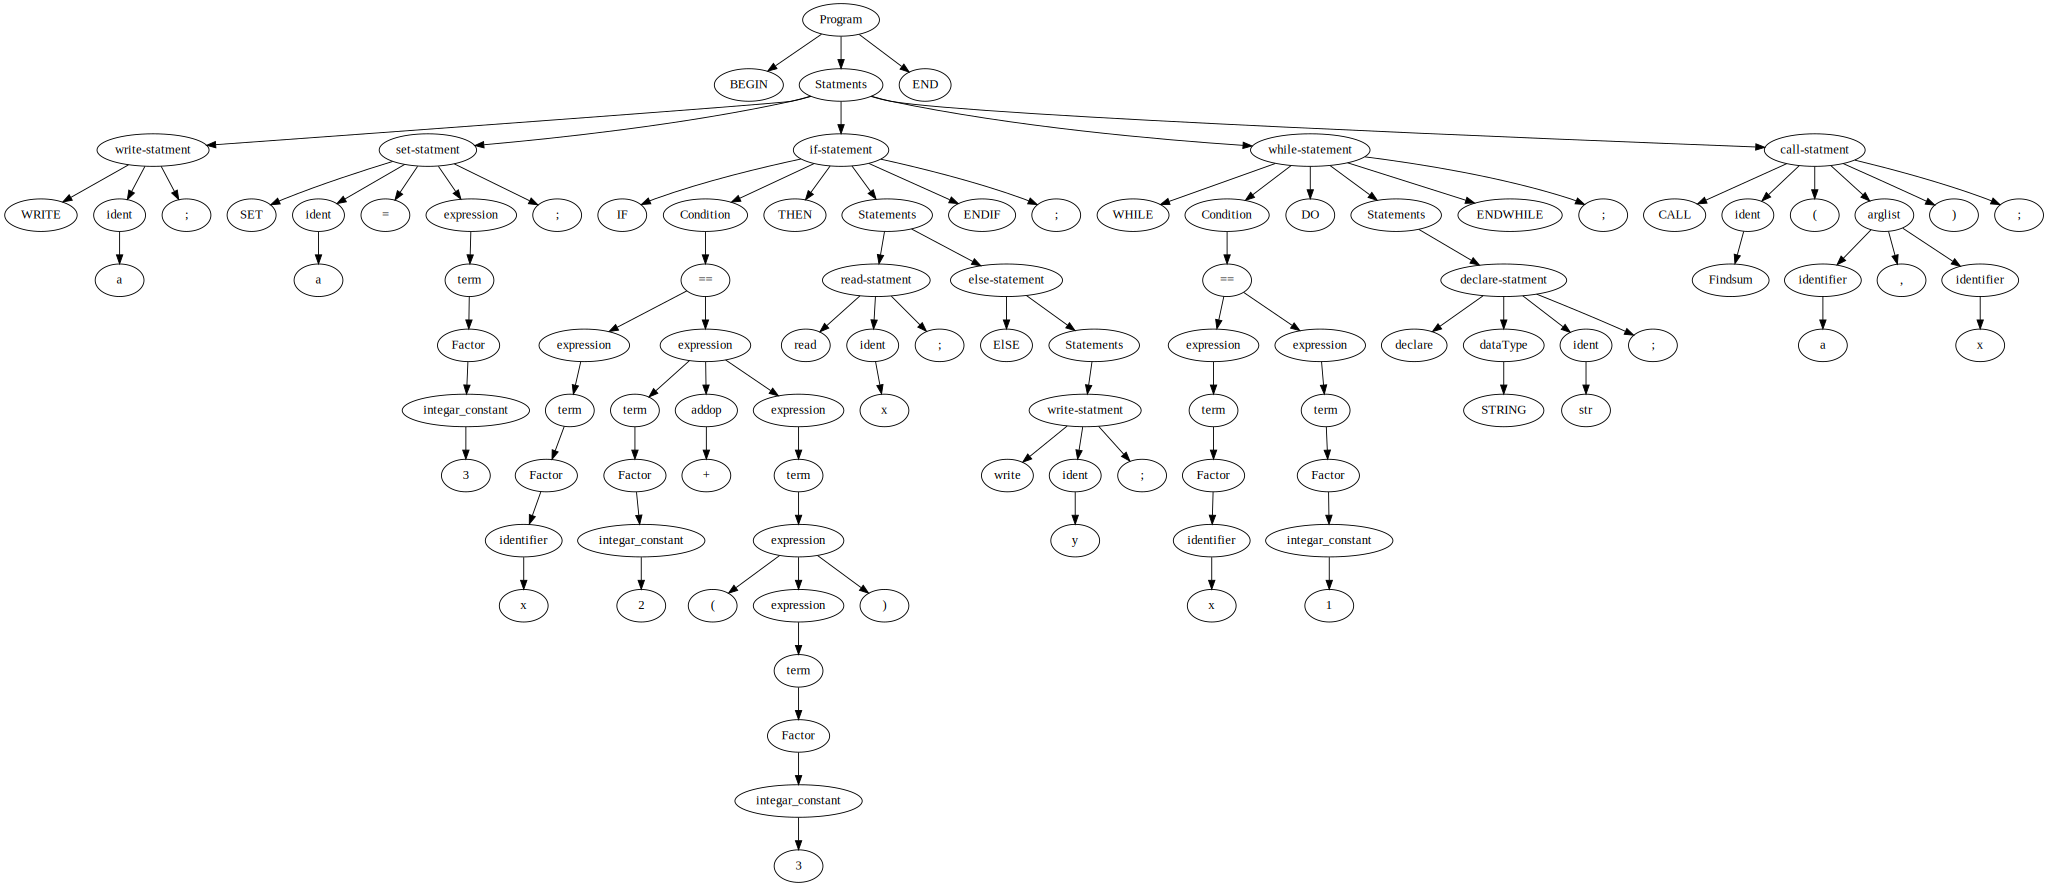

In [184]:
import graphviz

dot = graphviz.Digraph()

for i in range(len(nodes)):
    dot.node(nodes[i][0], nodes[i][1])
    dot.node(nodes[i][2], nodes[i][3])
    dot.edge(nodes[i][0],nodes[i][2])
dot

In [ ]:
dot.format = 'png'
dot.view(filename='digraph', directory='./')

## 3) Text File Input and Output

In [185]:
with open('Code_sample.txt') as f:
    lines = f.readlines()

In [186]:
def listToString(s): 
    str1 = " "     
    return (str1.join(s))

In [187]:
#Phase 1: Tokenizing
lines_string = listToString(lines)

with open('Tokenizing_phase.txt', 'w') as f:
    lexemes = scanner(lines_string)
    f.write('Tokenizing phase: \n')
    f.write('Lexemes output: \n')
    f.write('\n')
    
    for lexeme in lexemes:
        f.write(lexeme)
        f.write('\n')

In [188]:
#Phase 2: Identification
lexemes_string = listToString(lexemes)

with open('Identification_phase.txt', 'w') as f:
    tokens = identifier(lexemes)
    f.write('Identification phase: \n')
    f.write('Tokens output: \n')
    f.write('\n')
    
    for i in range(len(lexemes)):
        f.write(lexemes[i])
        f.write('\t')
        f.write(tokens[i])
        f.write('\n')

In [189]:
#Phase 3: Parsing
def ast_printer_for_text_file(node, indent=""): 
    if type(node) == Ast:   
        f.write(indent+f"node: {node.nodetype}")
        f.write('\n')
        if node.children:
            f.write(indent+"children: ")
            f.write('\n')
            for child in node.children:
                ast_printer_for_text_file(child, indent+"     ")
    elif isinstance(node, list): 
        for ast in node:
            ast_printer_for_text_file(ast)
    else:
        f.write(indent+f"{node}")
        f.write('\n')

ast = parser(lexemes, tokens)

with open('Parsing_phase.txt', 'w') as f:
    f.write('Parsing phase: \n')
    f.write('Parser output: \n')
    f.write('\n')
    ast_printer_for_text_file(ast)